In [2]:
!pip install geopandas

# Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import geopandas as gpd

# Dataset

In [4]:
df = pd.read_csv('/kaggle/input/indian-election-dataset/indian-national-level-election.csv')
df.head()

,st_name,year,pc_no,pc_name,pc_type,cand_name,cand_sex,partyname,partyabbre,totvotpoll,electors
0,Andaman & Nicobar Islands,1977,1,Andaman & Nicobar Islands,GEN,K.R. Ganesh,M,Independents,IND,25168,85308
1,Andaman & Nicobar Islands,1977,1,Andaman & Nicobar Islands,GEN,Manoranjan Bhakta,M,Indian National Congress,INC,35400,85308
2,Andaman & Nicobar Islands,1980,1,Andaman & Nicobar Islands,GEN,Ramesh Mazumdar,M,Independents,IND,109,96084
3,Andaman & Nicobar Islands,1980,1,Andaman & Nicobar Islands,GEN,Alagiri Swamy,M,Independents,IND,125,96084
4,Andaman & Nicobar Islands,1980,1,Andaman & Nicobar Islands,GEN,Kannu Chemy,M,Independents,IND,405,96084


## Preprocessing dataset

In [5]:
df['st_name'] = df['st_name'].replace('Andaman & Nicobar Islands', 'Andaman & Nicobar')
df['st_name'] = df['st_name'].replace('Chattisgarh', 'Chhattisgarh')
df['st_name'] = df['st_name'].replace('Goa Daman & Diu', 'Goa')
df['st_name'] = df['st_name'].replace('Goa, Daman & Diu', 'Goa')
df['st_name'] = df['st_name'].replace('Goa Daman & Diu', 'Goa')
df['st_name'] = df['st_name'].replace('Jammu & Kashmir', 'Jammu and Kashmir')
df['st_name'] = df['st_name'].replace('Jammu & Kashmir', 'Jammu and Kashmir')
df['st_name'] = df['st_name'].replace('Orissa', 'Odisha')
df['st_name'] = df['st_name'].replace('Pondicherry', 'Puducherry')
df['st_name'] = df['st_name'].replace('Uttaranchal', 'Uttarakhand')

In [6]:
df = df[df['st_name'] != 'Dadra & Nagar Haveli']
df = df[df['st_name'] != 'Daman & Diu']
df = df[df['st_name'] != 'National Capital Territory Of Delhi']
df = df[df['st_name'] != 'Nct Of Delhi']

# Voting trends

## Total voter turnout across years

In [150]:
def calculate_total_voter_turnout(data, year):
    total_eligible_voters = df[df['year'] == year]['electors'].unique().sum()
    actual_voters = df[df['year'] == year]['totvotpoll'].sum()
    voter_turnout = (actual_voters / total_eligible_voters) * 100
    return voter_turnout

In [151]:
def plot_total_voter_turnout(data):
    years = data['year'].unique()
    turnout_percentage = [calculate_total_voter_turnout(data, year) for year in years]
    
    plt.figure(figsize=(10, 6))
    plt.plot(years, turnout_percentage, marker='o', linestyle='-')
    plt.xlabel('Year')
    plt.ylabel('Voter Turnout Percentage')
    plt.title('Total Voter Turnout Across Years')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

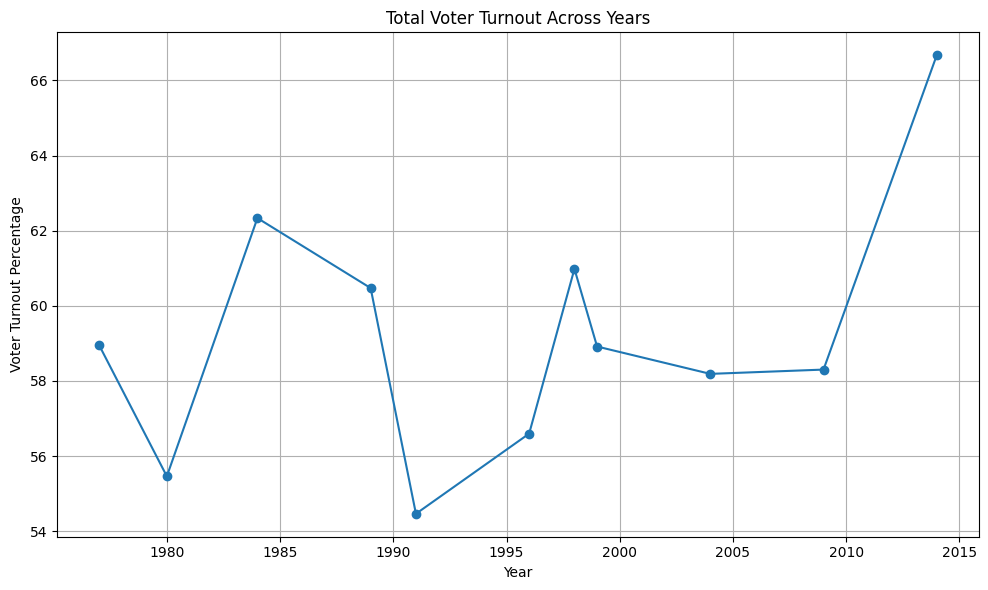

In [152]:
plot_total_voter_turnout(df)

## Vote share

In [7]:
def plot_party_distribution_constituency_pie_state(data, state, year, threshold=4):
    state_data = data[(data['st_name'] == state) & (data['year'] == int(year))]
    
    if state_data.empty:
        print(f"No elections data available for {state}.")
        return
    
    constituencies = state_data['pc_name'].unique()
    num_constituencies = len(constituencies)
    num_rows = num_constituencies // 2 + num_constituencies % 2  # Calculate the number of rows
    
    fig, axs = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))  # Create a grid layout
    
    for idx, constituency in enumerate(constituencies):
        row = idx // 2  # Calculate the row index
        col = idx % 2  # Calculate the column index
        
        filtered_data = state_data[state_data['pc_name'] == constituency]
        
        if filtered_data.empty:
            print(f"No elections data available for {constituency} in {state}.")
        else:
            party_distribution = filtered_data.groupby('partyabbre')['totvotpoll'].sum().reset_index()
            
            if len(party_distribution) > threshold:
                top_parties = party_distribution.nlargest(threshold, 'totvotpoll')
                others_votes = party_distribution[~party_distribution['partyabbre'].isin(top_parties['partyabbre'])]['totvotpoll'].sum()
                others_df = pd.DataFrame({'partyabbre': ['Others'], 'totvotpoll': [others_votes]})
                party_distribution = pd.concat([top_parties, others_df])
            
            axs[row, col].pie(party_distribution['totvotpoll'], labels=party_distribution['partyabbre'], autopct='%1.1f%%')
            axs[row, col].set_title(f'Party-wise Distribution in {constituency} - {state} ({year})')
    
    plt.tight_layout()
    plt.show()

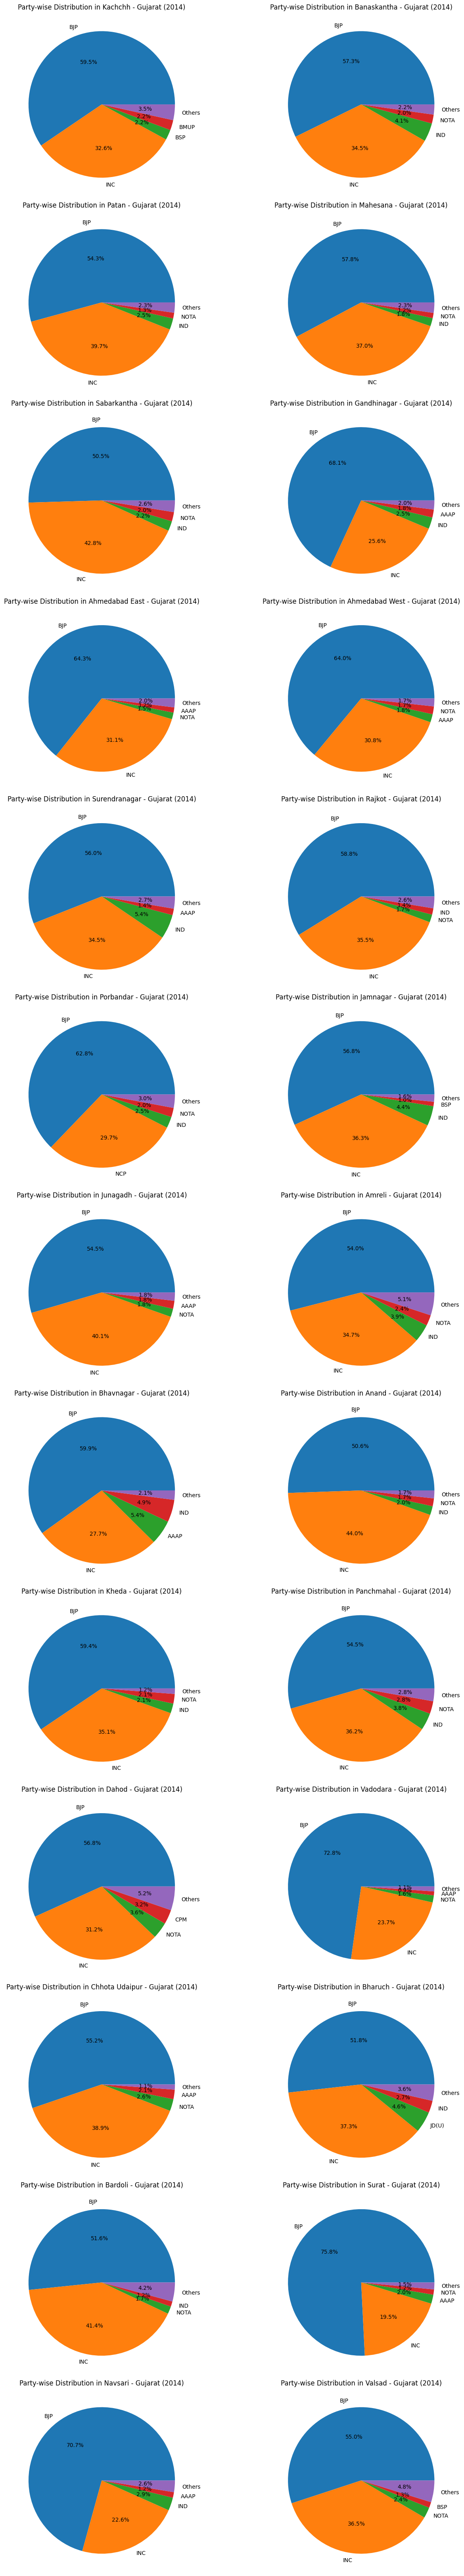

In [72]:
state = 'Gujarat'
year = '2014'
plot_party_distribution_constituency_pie_state(df, state, year)

In [9]:
def plot_party_distribution_state_pie(data, state, year, threshold=4):
    filtered_data = data[(data['st_name'] == state) & (data['year'] == int(year))]
    
    if filtered_data.empty:
        print("No elections! No data exists.")
    else:
        party_distribution = filtered_data.groupby('partyabbre')['totvotpoll'].sum().reset_index()
        
        if len(party_distribution) > threshold:
            top_parties = party_distribution.nlargest(threshold, 'totvotpoll')
            others_votes = party_distribution[~party_distribution['partyabbre'].isin(top_parties['partyabbre'])]['totvotpoll'].sum()
            others_df = pd.DataFrame({'partyabbre': ['Others'], 'totvotpoll': [others_votes]})
            party_distribution = pd.concat([top_parties, others_df])
        
        plt.figure(figsize=(5, 5))
        plt.pie(party_distribution['totvotpoll'], labels=party_distribution['partyabbre'], autopct='%1.1f%%')
        plt.title(f'Party-wise Distribution in {state} ({year})')
        plt.tight_layout()
        plt.show()

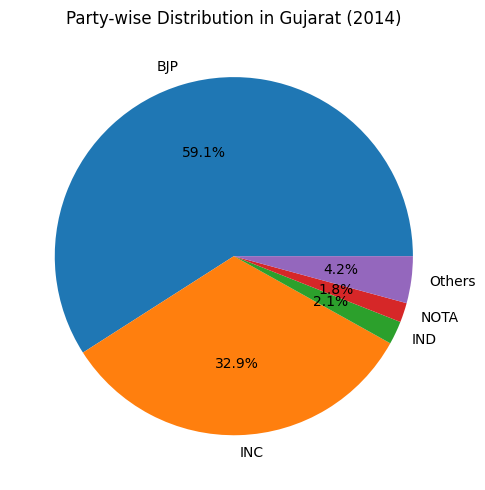

In [73]:
state = 'Gujarat'
year = '2014'
plot_party_distribution_state_pie(df, state, year)

In [11]:
def plot_party_distribution_national_pie(data, year, threshold=10):
    filtered_data = data[(data['year'] == int(year))]
    
    if filtered_data.empty:
        print("No elections! No data exists.")
    else:
        party_distribution = filtered_data.groupby('partyabbre')['totvotpoll'].sum().reset_index()
        
        if len(party_distribution) > threshold:
            top_parties = party_distribution.nlargest(threshold, 'totvotpoll')
            others_votes = party_distribution[~party_distribution['partyabbre'].isin(top_parties['partyabbre'])]['totvotpoll'].sum()
            others_df = pd.DataFrame({'partyabbre': ['Others'], 'totvotpoll': [others_votes]})
            party_distribution = pd.concat([top_parties, others_df])
        
        plt.figure(figsize=(5, 5))
        plt.pie(party_distribution['totvotpoll'], labels=party_distribution['partyabbre'], autopct='%1.1f%%')
        plt.title(f'Party-wise Distribution in India ({year})')
        plt.tight_layout()
        plt.show()

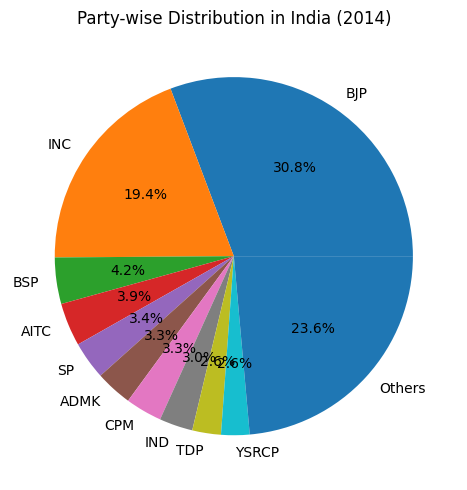

In [12]:
year = '2014'
plot_party_distribution_national_pie(df, year)

## Vote share

In [13]:
def plot_votes_by_constituency_horizontal_bar(data, state, constituency, year, threshold=6):
    pc_data = data[(data['st_name'] == state) & (data['pc_name'] == constituency) & (data['year'] == int(year))]
    if len(pc_data) == 0:
        print(f"No data available for {constituency} for {year}.")
        return
    
    party_votes = pc_data.groupby('partyabbre')['totvotpoll'].sum().sort_values(ascending=False)
    
    top_parties = party_votes.head(threshold)
    other_votes = party_votes[threshold:].sum()
    top_parties['Others'] = other_votes
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=top_parties.values, y=top_parties.index, orient='h')
    plt.xlabel('Total Votes')
    plt.ylabel('Party')
    plt.title(f'Votes by Party in {constituency}, {state} in {year}')
    plt.show()

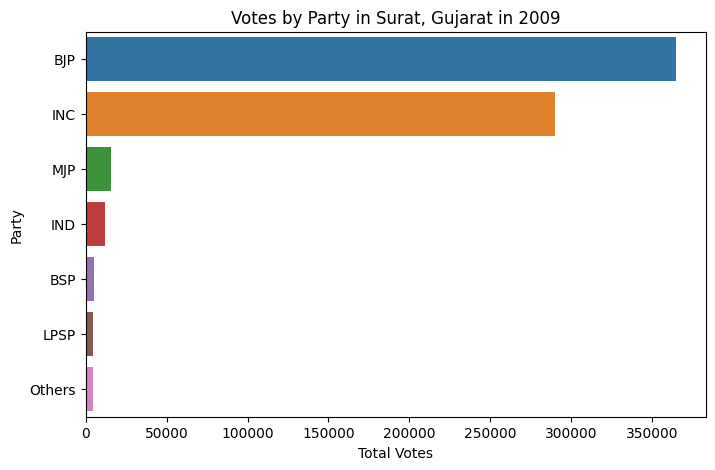

In [14]:
state = 'Gujarat'
constituency = 'Surat'
year = '2009'
plot_votes_by_constituency_horizontal_bar(df, state, constituency, year)

In [15]:
def plot_votes_by_state_horizontal_bar(data, state, constituency, year, threshold=7):
    pc_data = data[(data['st_name'] == state) & (data['year'] == int(year))]
    if len(pc_data) == 0:
        print(f"No data available for {state} for {year}.")
        return
    
    party_votes = pc_data.groupby('partyabbre')['totvotpoll'].sum().sort_values(ascending=False)
    
    top_parties = party_votes.head(threshold)
    other_votes = party_votes[threshold:].sum()
    top_parties['Others'] = other_votes
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=top_parties.values, y=top_parties.index, orient='h')
    plt.xlabel('Total Votes')
    plt.ylabel('Party')
    plt.title(f'Votes by Party in {state} in {year}')
    plt.show()

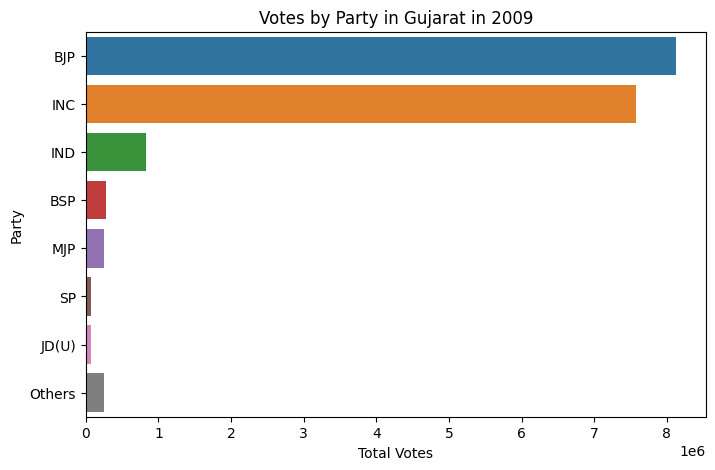

In [16]:
state = 'Gujarat'
year = '2009'
plot_votes_by_state_horizontal_bar(df, state, constituency, year)

In [17]:
def plot_votes_by_national_horizontal_bar(data, year, threshold=8):
    pc_data = data[(data['year'] == int(year))]
    if len(pc_data) == 0:
        print(f"No data available for {year}.")
        return
    
    party_votes = pc_data.groupby('partyabbre')['totvotpoll'].sum().sort_values(ascending=False)
    
    top_parties = party_votes.head(threshold)
    other_votes = party_votes[threshold:].sum()
    top_parties['Others'] = other_votes
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=top_parties.values, y=top_parties.index, orient='h')
    plt.xlabel('Total Votes')
    plt.ylabel('Party')
    plt.title(f'Votes by Party in India in {year}')
    plt.show()

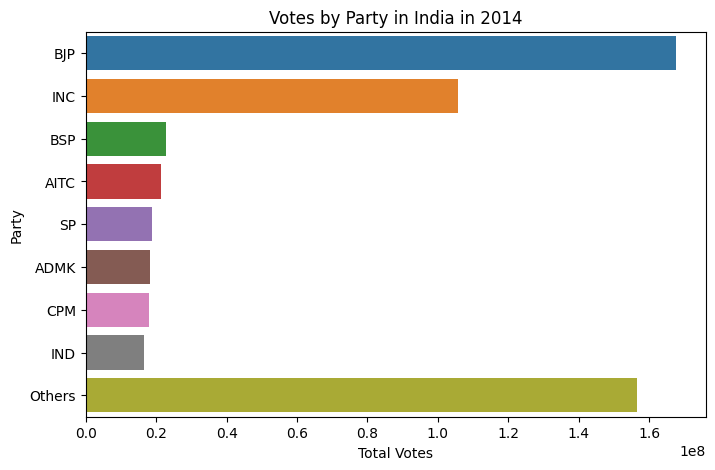

In [18]:
year = '2014'
plot_votes_by_national_horizontal_bar(df, year)

## Comprehensive Analysis of voting pattern in state

In [111]:
def generate_visualizations(data, state, year, threshold=5):
    state_data = data[(data['st_name'] == state) & (data['year'] == int(year))]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    party_vote_share = state_data.groupby('partyabbre')['totvotpoll'].sum().reset_index()
    party_vote_share = party_vote_share.sort_values(by='totvotpoll', ascending=False).head(10)
    
    if len(party_vote_share) > threshold:
            top_parties = party_vote_share.nlargest(threshold, 'totvotpoll')
            others_votes = party_vote_share[~party_vote_share['partyabbre'].isin(top_parties['partyabbre'])]['totvotpoll'].sum()
            others_df = pd.DataFrame({'partyabbre': ['Others'], 'totvotpoll': [others_votes]})
            party_vote_share = pd.concat([top_parties, others_df])
            
    sns.barplot(x='partyabbre', y='totvotpoll', data=party_vote_share, ax=axes[0, 0])
    axes[0, 0].set_title('Top 10 Parties by Vote Share')
    axes[0, 0].set_xlabel('Party Abbreviation')
    axes[0, 0].set_ylabel('Total Votes')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    party_vote_share.set_index('partyabbre', inplace=True)
    party_vote_share.plot.pie(y='totvotpoll', ax=axes[0, 1], autopct='%1.1f%%', legend=None)
    axes[0, 1].set_title('Party-wise Vote Share')
    axes[0, 1].set_ylabel('')
    
    gender_distribution = state_data['cand_sex'].value_counts()
    gender_distribution.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], ax=axes[1, 0])
    axes[1, 0].set_title('Gender Distribution of Candidates')
    axes[1, 0].set_ylabel('')
    
    sns.boxplot(x='cand_sex', y='totvotpoll', data=state_data, ax=axes[1, 1])
    axes[1, 1].set_title('Vote Distribution by Candidate Gender')
    axes[1, 1].set_xlabel('Candidate Gender')
    axes[1, 1].set_ylabel('Total Votes')
    
    plt.tight_layout()
    plt.show()

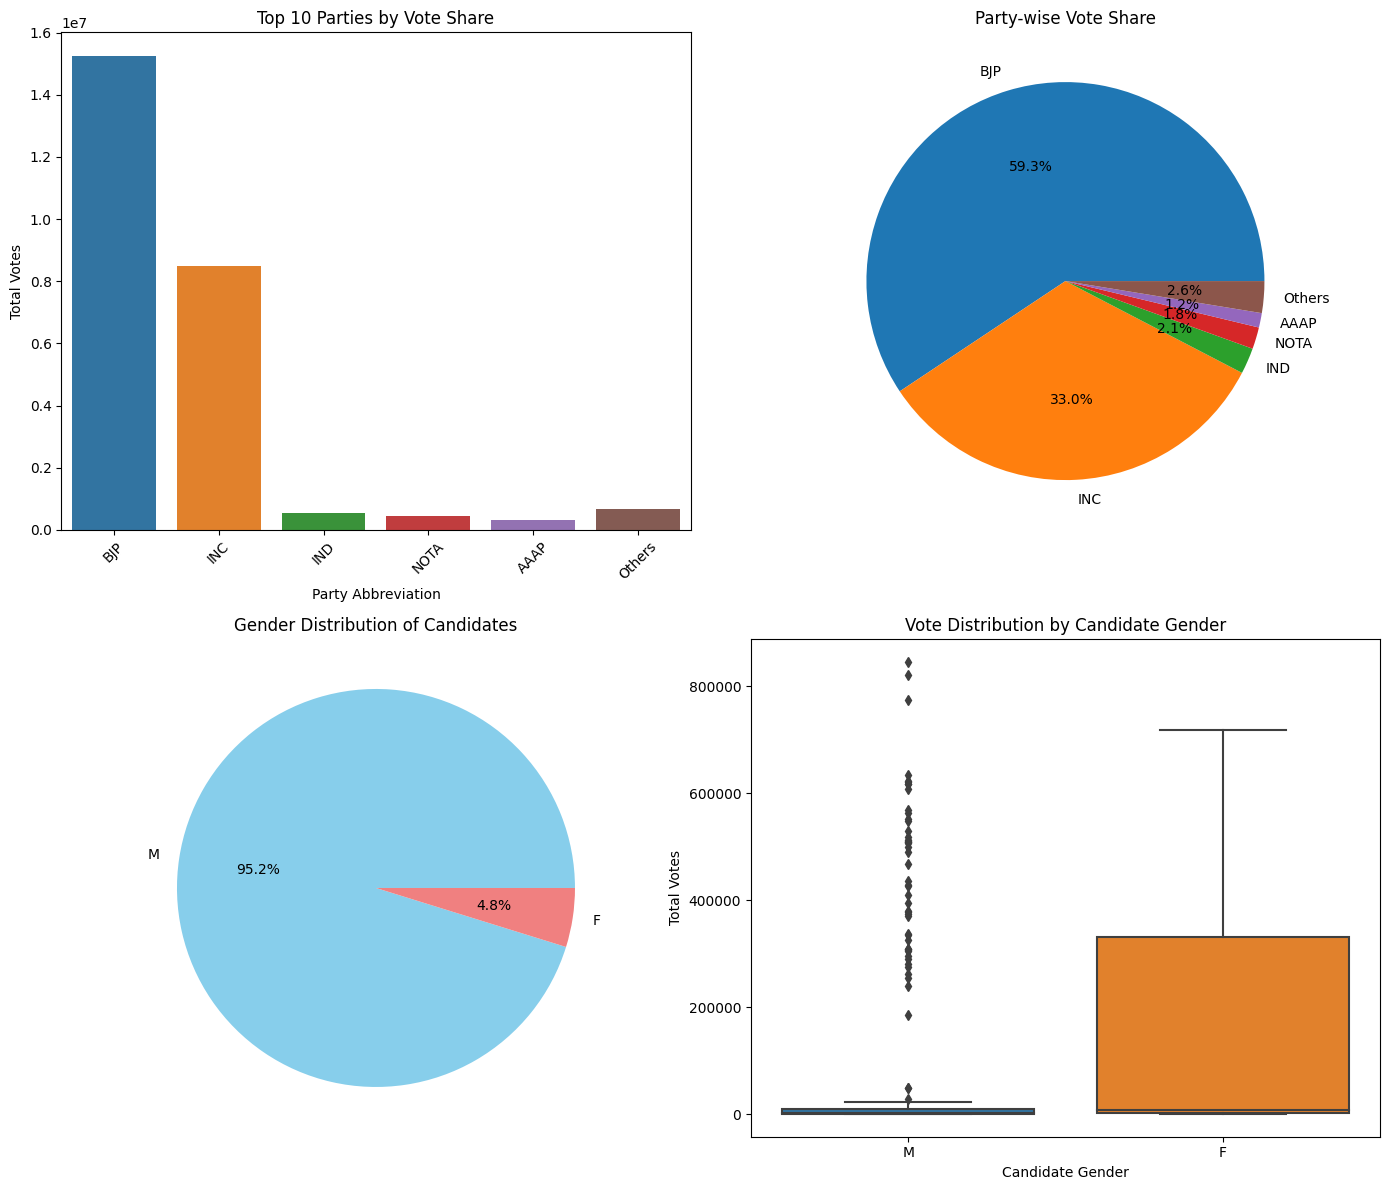

In [112]:
state = 'Gujarat'
year = '2014'
generate_visualizations(df, state, year)

## Number of votes across years

In [19]:
def plot_party_distribution_constituency_line(data, parties, state, constituency):
    plt.figure(figsize=(10, 5))
    for party in parties:
        filtered_data = data[(data['partyabbre'] == party) & (data['st_name'] == state) & (data['pc_name'] == constituency)]
        party_distribution = filtered_data.groupby('year')['totvotpoll'].sum().reset_index()
        if party_distribution.empty:
            print(f"No data available for party {party} in {state}, {constituency}.")
        else:
            plt.plot(party_distribution['year'], party_distribution['totvotpoll'], marker='o', linestyle='-', label=party)
    plt.xlabel('Year')
    plt.ylabel('Total Votes')
    plt.title(f'Trend of Votes for Parties in {constituency} - {state}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

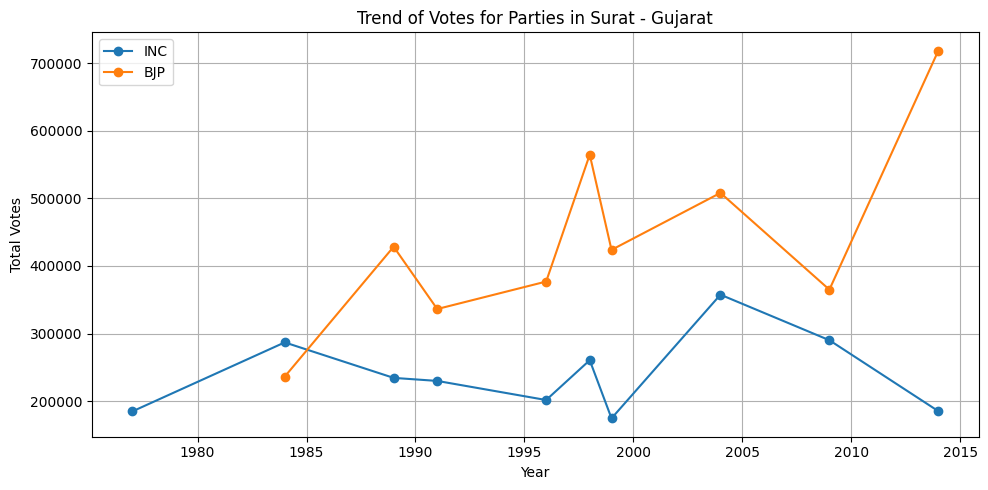

In [20]:
parties = ['INC', 'BJP']
state = 'Gujarat'
constituency = 'Surat'
plot_party_distribution_constituency_line(df, parties, state, constituency)

In [21]:
def plot_party_distribution_state_line(data, parties, state):
    plt.figure(figsize=(10, 5))
    for party in parties:
        filtered_data = data[(data['partyabbre'] == party) & (data['st_name'] == state)]
        party_distribution = filtered_data.groupby('year')['totvotpoll'].sum().reset_index()
        if party_distribution.empty:
            print(f"No data available for party {party} in {state}.")
        else:
            plt.plot(party_distribution['year'], party_distribution['totvotpoll'], marker='o', linestyle='-', label=party)
    plt.xlabel('Year')
    plt.ylabel('Total Votes')
    plt.title(f'Trend of Votes for parties in {state}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

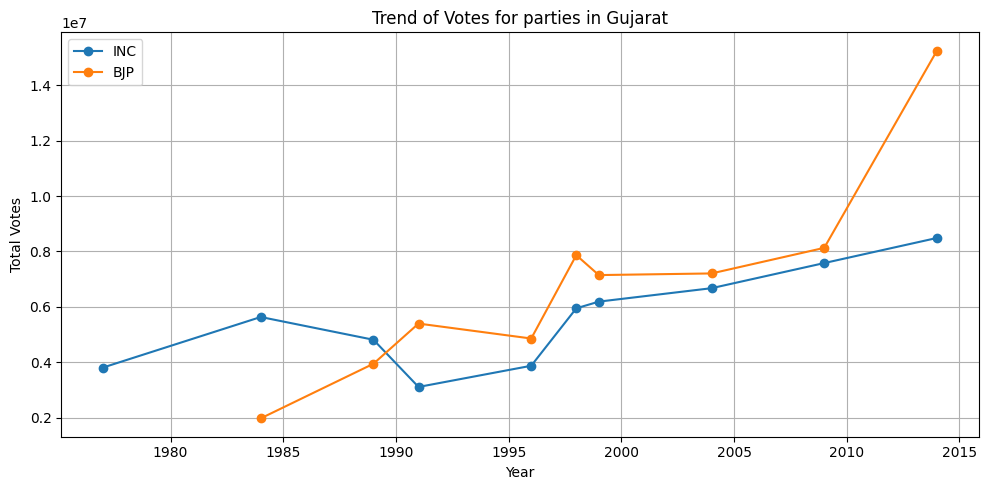

In [75]:
parties = ['INC', 'BJP']
state = 'Gujarat'
plot_party_distribution_state_line(df, parties, state)

In [23]:
def plot_party_distribution_national_line(data, parties):
    plt.figure(figsize=(10, 5))
    for party in parties:
        filtered_data = data[(data['partyabbre'] == party)]
        party_distribution = filtered_data.groupby('year')['totvotpoll'].sum().reset_index()
        if party_distribution.empty:
            print(f"No data available for party {party}.")
        else:
            plt.plot(party_distribution['year'], party_distribution['totvotpoll'], marker='o', linestyle='-', label=party)
    plt.xlabel('Year')
    plt.ylabel('Total Votes')
    plt.title('Trend of Votes for Parties in India')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

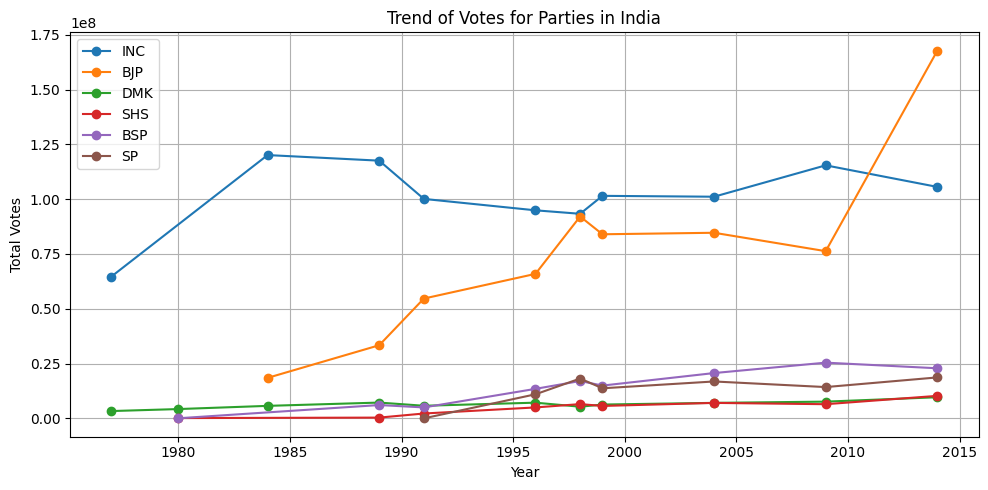

In [77]:
parties = ['INC', 'BJP', 'DMK', 'SHS', 'BSP', 'SP']
plot_party_distribution_national_line(df, parties)

## Candidate Sex distribution

In [25]:
def plot_candidate_sex_distribution_state_pie(data, party, year, state):
    party_year_data = data[(data['partyabbre'] == party) & (data['year'] == int(year)) & (data['st_name'] == state)]
    if len(party_year_data) == 0:
        print(f"No data available for party {party}.")
        return
    
    sex_counts = party_year_data['cand_sex'].value_counts()
    plt.figure(figsize=(5, 5))
    plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Candidate Sex Distribution for {party} in {state} ({year})')
    plt.show()

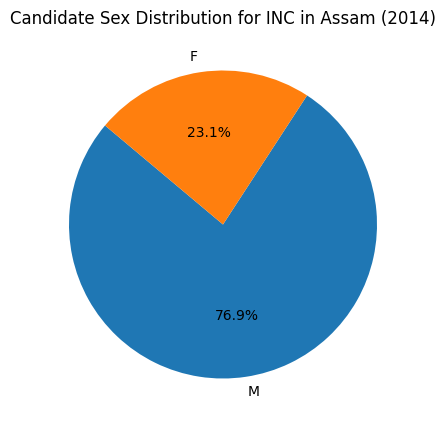

In [26]:
party = 'INC'
year = '2014'
state = 'Assam'
plot_candidate_sex_distribution_state_pie(df, party, year, state)

In [27]:
def plot_candidate_sex_distribution_national_pie(data, party, year):
    party_year_data = data[(data['partyabbre'] == party) & (data['year'] == int(year))]
    if len(party_year_data) == 0:
        print(f"No data available for party {party} for {year}.")
        return
    
    sex_counts = party_year_data['cand_sex'].value_counts()
    plt.figure(figsize=(5, 5))
    plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Candidate Sex Distribution for {party} in India ({year})')
    plt.show()

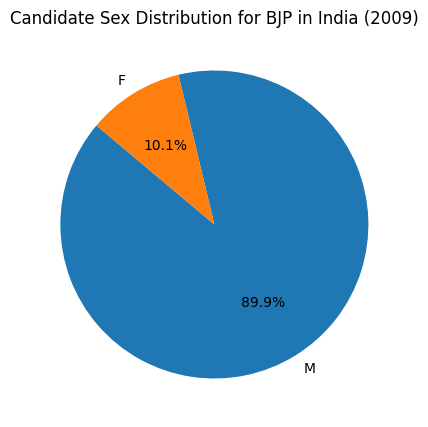

In [28]:
party = 'BJP'
year = '2009'
plot_candidate_sex_distribution_national_pie(df, party, year)

## Top parties by number of candidates and vote share visualised on wordcloud

In [29]:
def plot_top_10_parties_by_candidates(data, year):
    data_year = data[data['year'] == year]
    party_counts = data_year['partyabbre'].value_counts()
    top_parties = party_counts.head(int(len(party_counts) * 0.1))

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_parties)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud of Top 10% Parties by Number of Candidates in {year}')
    plt.axis('off')
    plt.show()

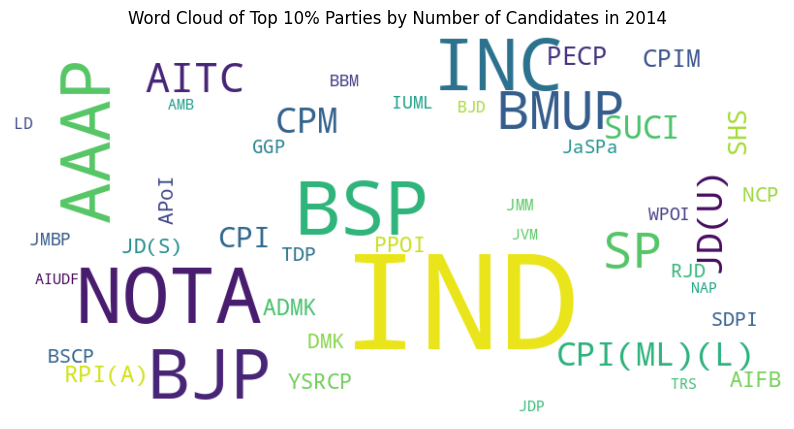

In [30]:
plot_top_10_parties_by_candidates(df, 2014)

In [31]:
def plot_top_10_parties_by_vote_share(data, year):
    data_year = data[data['year'] == year]
    total_votes = data_year['totvotpoll'].sum()
    party_vote_share = data_year.groupby('partyabbre')['totvotpoll'].sum()
    party_vote_share_percentage = (party_vote_share / total_votes) * 100
    
    top_parties = party_vote_share_percentage.sort_values(ascending=False).head(int(len(party_vote_share_percentage) * 0.1))
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_parties)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud of Top 10% Parties by Vote Share in {year}')
    plt.axis('off')
    plt.show()

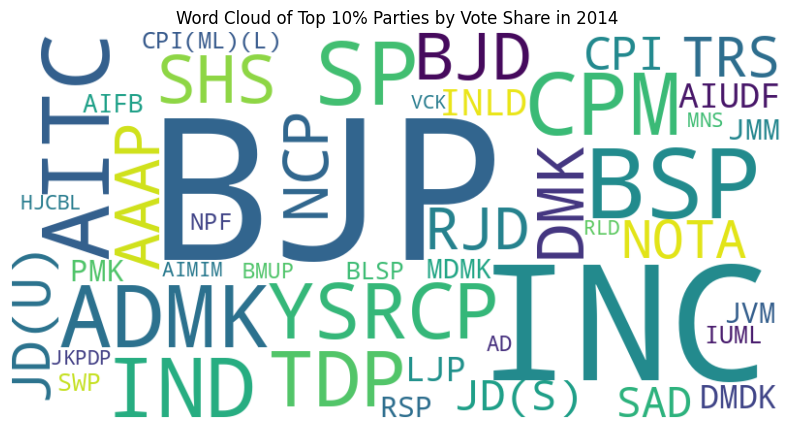

In [32]:
plot_top_10_parties_by_vote_share(df, 2014)

## Vote share visualised on map

In [66]:
fp = '/kaggle/input/state-boundary/India_State_Boundary.shp'

map_df = gpd.read_file(fp)
map_df.head()

,State_Name,geometry
0,Andaman & Nicobar,"MULTIPOLYGON (((10341718.474 1449533.161, 1034..."
1,Chandigarh,"POLYGON ((8546255.616 3606050.813, 8546315.400..."
2,Daman and Diu and Dadra and Nagar Haveli,"MULTIPOLYGON (((8122247.822 2312434.407, 81223..."
3,Delhi,"POLYGON ((8583390.570 3359116.190, 8583476.212..."
4,Haryana,"POLYGON ((8524318.539 3516490.865, 8524451.392..."


In [67]:
map_df['State_Name'] = map_df['State_Name'].replace('Chhattishgarh', 'Chhattisgarh')
map_df['State_Name'] = map_df['State_Name'].replace('Tamilnadu', 'Tamil Nadu')

In [88]:
def plot_party_votes_map(map_df, data, party, year):
    state_total_votes = data[data['year'] == int(year)].groupby('st_name')['totvotpoll'].sum().reset_index()
    
    party_votes = data[(data['year'] == int(year)) & (data['partyabbre'] == party)].groupby('st_name')['totvotpoll'].sum().reset_index()
    
    merged_df = map_df.merge(state_total_votes, left_on='State_Name', right_on='st_name', how='left')
    merged_df = merged_df.merge(party_votes, on='st_name', how='left')
    
    merged_df['vote_percentage'] = (merged_df['totvotpoll_y'] / merged_df['totvotpoll_x']) * 100
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    
    merged_df.plot(column='vote_percentage', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
                   missing_kwds={'color': 'lightgrey', 'label': 'No Data'})
    
    ax.set_title(f'Vote Percentage for {party} in {year}')
    plt.axis('off')
    plt.show()

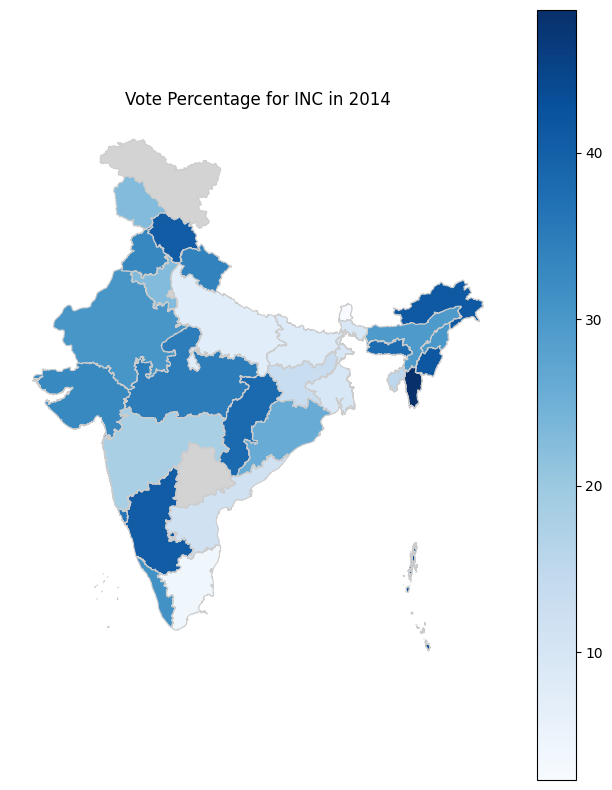

In [89]:
party = 'INC'
year = '2014'
plot_party_votes_map(map_df, df, party, year)

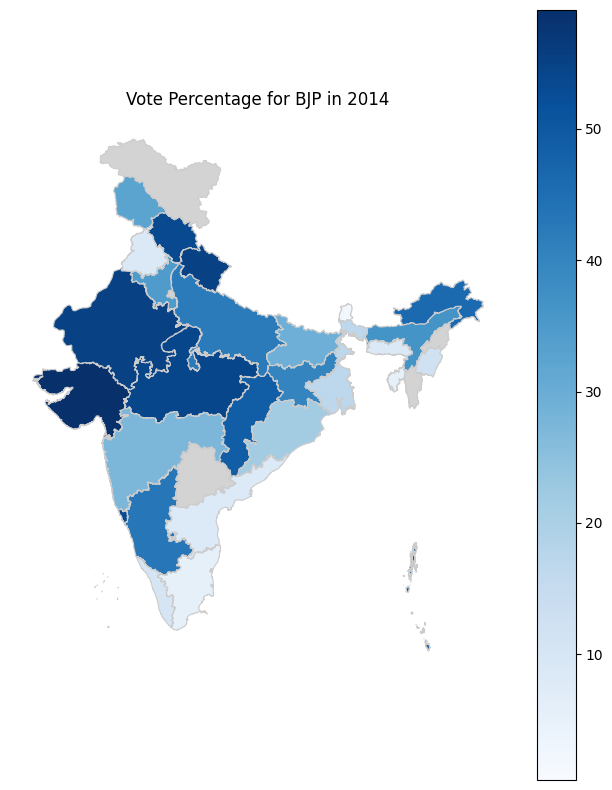

In [90]:
party = 'BJP'
year = '2014'
plot_party_votes_map(map_df, df, party, year)